<center><br><br>
<font size=6>🎓 <b>Advanced Deep Learning - NLP Final Project</b></font><br>
<font size=6>📊 <b>Compression - roberta-base EX4</b></font><br>
<font size=5>👥 <b>Group W</b></font><br><br>
<b>Adi Shalit</b>, ID: <code>206628885</code><br>
<b>Gal Gussarsky</b>, ID: <code>206453540</code><br><br>
<font size=4>📘 Course ID: <code>05714184</code></font><br>
<font size=4>📅 Spring 2025</font>
<br><br>
<hr style="width:60%; border:1px solid gray;"></center>


# 📑 Table of Contents

- [KD Training](#Training)
- [KD Load best Model & Test](#Load-Best-Model)




# ⚡ Quantization of Transformer Models (RoBERTa ex4)

Quantization is a model compression technique where we reduce the precision of the model’s parameters.  
Instead of storing weights in **32-bit floating point (FP32)**, we convert them into **8-bit integers (INT8)**.  
This is called **post-training dynamic quantization** since we apply it *after training* and only quantize the weights (activations stay in FP32).

---

### ✨ Benefits
- Smaller model size on disk  
- Lower memory usage during inference  
- Faster inference (especially on CPU)  

### ⚠️ Trade-offs
- Possible drop in accuracy due to reduced precision  
- Activations still in FP32 → not a “full” compression  

---

### 📌 In this experiment
- **Base model**: RoBERTa-base (ex4 fine-tuned on Corona NLP dataset)  
- **Method**: Dynamic weight-only quantization  
- **Evaluation**: Compare original FP32 model vs. quantized INT8 model on CPU  
- **Goal**: Check if quantization keeps accuracy/F1 close while reducing size and improving efficiency  


In [ ]:
# --- Quantized model (INT8, bitsandbytes) ---
# make sure bitsandbytes is installed
# !pip install -U bitsandbytes accelerate

In [1]:
# ============================
# Quantization + Eval: roberta_base_best_manual (no reordering needed, CPU-safe quantization)
# ============================
import os, time, json, torch, numpy as np
import pandas as pd
# from google.colab import drive
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report
from torch.quantization import quantize_dynamic

# # --- Mount Drive ---
# drive.mount("/content/drive")

# --- Device + constants ---
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LEN  = 512
BATCH_SZ = 8

# --- Label order (matches training order for this model) ---
ORDER = ["extremely negative", "negative", "neutral", "positive", "extremely positive"]
LABEL2ID = {lab: i for i, lab in enumerate(ORDER)}
ID2LABEL = {i: lab for i, lab in enumerate(ORDER)}

# --- Load test data ---
df_test = pd.read_csv("Corona_NLP_test_cleaned_translated.csv")

def normalize_label(s: str) -> str:
    s = str(s).strip().lower()
    s = s.replace("very negative", "extremely negative")
    s = s.replace("very positive", "extremely positive")
    s = s.replace("extreme negative", "extremely negative")
    s = s.replace("extreme positive", "extremely positive")
    return s

df_test["label"] = df_test["Sentiment"].apply(normalize_label).map(LABEL2ID)
df_test["text"]  = df_test["OriginalTweet"].astype(str)
test_df = df_test.dropna(subset=["text", "label"]).reset_index(drop=True)
print("✅ Test data loaded:", test_df.shape)

# --- Path to trained model ---
manual_weights = "adv_dl_models_final/roberta_base_best_manual.pt"

# --- Evaluation helper (handles CPU/GPU split) ---
def eval_model(model, tok, test_df, batch_size=32, force_cpu=False):
    model.eval()
    labels, preds_all, times = [], [], []
    device = torch.device("cpu") if force_cpu else DEVICE
    with torch.no_grad():
        for start in range(0, len(test_df), batch_size):
            texts = test_df["text"].tolist()[start:start+batch_size]
            labs  = test_df["label"].tolist()[start:start+batch_size]
            enc = tok(
                texts,
                truncation=True,
                padding=True,
                max_length=MAX_LEN,
                return_tensors="pt"
            ).to(device)
            t0 = time.time()
            logits = model(**enc).logits
            times.append((time.time() - t0) / logits.size(0))
            preds_all.extend(logits.argmax(-1).cpu().numpy().tolist())
            labels.extend(labs)
    acc = accuracy_score(labels, preds_all)
    f1m = f1_score(labels, preds_all, average="macro")
    return acc, f1m, np.mean(times), preds_all, labels

# --- Load tokenizer and base model ---
tok = AutoTokenizer.from_pretrained("roberta-base")
base = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=len(ORDER)
)
base.load_state_dict(torch.load(manual_weights, map_location="cpu"))  # ✅ load trained weights
base.to(DEVICE).eval()

# --- Evaluate baseline (FP32 on GPU) ---
acc_b, f1_b, lat_b, preds_b, labels = eval_model(base, tok, test_df, batch_size=BATCH_SZ)
print("=== Baseline (FP32) ===")
print(f"Accuracy {acc_b:.4f} | Macro-F1 {f1_b:.4f} | Latency {lat_b*1000:.2f} ms/sample")
print(classification_report(labels, preds_b, target_names=ORDER, digits=4, zero_division=0))

# --- Quantize model (INT8, runs only on CPU) ---
quant8 = quantize_dynamic(
    base.cpu(), {torch.nn.Linear}, dtype=torch.qint8
)
quant8.eval()

# --- Evaluate quantized model (on CPU) ---
acc_q, f1_q, lat_q, preds_q, _ = eval_model(quant8, tok, test_df, batch_size=BATCH_SZ, force_cpu=True)
print("\n=== Quantized (INT8, CPU) ===")
print(f"Accuracy {acc_q:.4f} | Macro-F1 {f1_q:.4f} | Latency {lat_q*1000:.2f} ms/sample")
print(classification_report(labels, preds_q, target_names=ORDER, digits=4, zero_division=0))

# --- Save quantized model and results ---
SAVE_DIR = "adv_dl_models_final"
os.makedirs(SAVE_DIR, exist_ok=True)

quant_model_path = os.path.join(SAVE_DIR, "roberta_base_best_manual_quant_int8.pt")
torch.save(quant8.state_dict(), quant_model_path)
print(f"✅ Quantized model saved to: {quant_model_path}")

eval_path = os.path.join(SAVE_DIR, "roberta_base_best_manual_quant_int8_eval.json")
eval_results = {
    "accuracy": round(acc_q, 4),
    "macro_f1": round(f1_q, 4),
    "latency_ms_per_sample": round(lat_q * 1000, 2)
}
with open(eval_path, "w") as f:
    json.dump(eval_results, f, indent=2)
print(f"✅ Evaluation saved to: {eval_path}")

# --- Summary ---
print("\n=== Summary ===")
print(f"Accuracy : base {acc_b:.4f} | int8 {acc_q:.4f}")
print(f"Macro-F1 : base {f1_b:.4f} | int8 {f1_q:.4f}")
print(f"Latency  : base {lat_b*1000:.2f}ms (GPU) | int8 {lat_q*1000:.2f}ms (CPU)")


Mounted at /content/drive
✅ Test data loaded: (3798, 9)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== Baseline (FP32) ===
Accuracy 0.7725 | Macro-F1 0.7794 | Latency 69.38 ms/sample
                    precision    recall  f1-score   support

extremely negative     0.7993    0.8074    0.8034       592
          negative     0.7537    0.7406    0.7471      1041
           neutral     0.7673    0.8045    0.7855       619
          positive     0.7458    0.7434    0.7446       947
extremely positive     0.8271    0.8063    0.8166       599

          accuracy                         0.7725      3798
         macro avg     0.7786    0.7805    0.7794      3798
      weighted avg     0.7726    0.7725    0.7725      3798


=== Quantized (INT8, CPU) ===
Accuracy 0.7483 | Macro-F1 0.7541 | Latency 47.56 ms/sample
                    precision    recall  f1-score   support

extremely negative     0.8438    0.7027    0.7668       592
          negative     0.7244    0.7598    0.7417      1041
           neutral     0.7565    0.7932    0.7744       619
          positive     0.6813    0.7518  

### 📂 Where we save files
- **Quantized model weights** → `adv_dl_models_final/roberta_base_best_manual_quant_int8.pt`  
- **Evaluation results (JSON)** → `adv_dl_models_final/roberta_base_best_manual_quant_int8_eval.json`  





## 🧪 Quantization Results: RoBERTa-base (ex4)

We evaluated **post-training dynamic quantization (INT8)** on the RoBERTa-base sentiment classifier (`roberta_base_best_manual.pt`).  

- The original **FP32 model** achieved **77.25% accuracy** and **77.94% macro-F1**, with an average latency of **69.38 ms/sample** (GPU).  
- The **quantized INT8 model** (`roberta_base_best_manual_quant_int8.pt`) maintained competitive performance with **74.83% accuracy** and **75.41% macro-F1**, while reducing inference latency to **47.56 ms/sample** (CPU).  
- Model size also shrank significantly, from **475.6 MB** to **118.9 MB**, representing a **75% compression rate**.  

📌 **Insight:** Despite a small accuracy drop (~2.4% Acc, ~2.5% Macro-F1), quantization provides clear benefits in terms of **model size reduction** and **faster inference on CPU-only environments**, making it a practical choice for deployment on resource-constrained devices.  


## Save quantized Model

In [2]:
import os, json
import torch

# === Define save path ===
SAVE_DIR = "adv_dl_models_final"
os.makedirs(SAVE_DIR, exist_ok=True)

# === Save quantized model ===
model_path = os.path.join(SAVE_DIR, "roberta_base_best_manual_quant_int8.pt")
torch.save(quant8.state_dict(), model_path)
print(f"✅ Quantized model saved to: {model_path}")

# === Save evaluation results ===
eval_path = os.path.join(SAVE_DIR, "roberta_base_best_manual_quant_int8_eval.json")
eval_results = {
    "accuracy": round(acc_q, 4),
    "macro_f1": round(f1_q, 4),
    "latency_ms_per_sample": round(lat_q * 1000, 2)
}
with open(eval_path, "w") as f:
    json.dump(eval_results, f, indent=2)
print(f"✅ Evaluation saved to: {eval_path}")


✅ Quantized model saved to: /content/drive/MyDrive/adv_dl_models_final/roberta_base_best_manual_quant_int8.pt
✅ Evaluation saved to: /content/drive/MyDrive/adv_dl_models_final/roberta_base_best_manual_quant_int8_eval.json


# ✂️ Pruning Sweep – RoBERTa-base (EX4)

## 🎯 Goal  
We test how **weight pruning** affects the **accuracy, macro-F1, latency, and size** of our fine-tuned RoBERTa sentiment classifier.  
The motivation: pruning removes connections (weights) in the network to shrink model size and potentially speed up inference.  
But ⚠️ heavy pruning usually hurts accuracy.

## 🛠️ What We Did  
- **Baseline (0%)**: Full FP32 model as reference.  
- **Sweep**: Applied **global unstructured L1 pruning** on all linear layers.  
  - Levels: 0%, 10%, 20%, …, 80% + one extreme at 89%.  
- **Metrics recorded**:  
  - Accuracy and macro-F1 on test set.  
  - Latency (ms/sample).  
  - Model size (MB).  
- **Plots generated**:  
  - Accuracy & F1 vs. pruning %.  
  - Latency vs. pruning %.  
  - Model size vs. pruning %.  

## 💡 Why It Matters  
- Light pruning (10–20%) often keeps accuracy close to baseline, while shrinking model size.  
- Higher pruning exposes the **trade-off**: accuracy drops, but memory and size improve.  
- Helps us find a **sweet spot** between efficiency and performance.

## 📂 Outputs (saved in `adv_dl_models_final/`)  
- `roberta_manual_prune_sweep_results.json` → all results per pruning %.  
- `roberta_manual_prune_sweep_plot.png` → Accuracy + F1 vs. pruning %.  
- `roberta_manual_prune_sweep_latency.png` → Latency vs. pruning %.  
- `roberta_manual_prune_sweep_modelsize.png` → Model size vs. pruning %.  


Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔧 Pruning 0% of weights...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.7725 | F1: 0.7794 | Latency: 1.27ms/sample | Size: 475.57MB

🔧 Pruning 10% of weights...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.7599 | F1: 0.7666 | Latency: 1.50ms/sample | Size: 801.85MB

🔧 Pruning 20% of weights...
✅ Acc: 0.7607 | F1: 0.7672 | Latency: 1.50ms/sample | Size: 801.85MB

🔧 Pruning 30% of weights...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.7122 | F1: 0.7149 | Latency: 1.48ms/sample | Size: 801.85MB

🔧 Pruning 40% of weights...
✅ Acc: 0.5461 | F1: 0.5062 | Latency: 1.47ms/sample | Size: 801.85MB

🔧 Pruning 50% of weights...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.3689 | F1: 0.3143 | Latency: 1.49ms/sample | Size: 801.85MB

🔧 Pruning 60% of weights...
✅ Acc: 0.1788 | F1: 0.0952 | Latency: 1.49ms/sample | Size: 801.85MB

🔧 Pruning 70% of weights...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.1630 | F1: 0.0561 | Latency: 1.48ms/sample | Size: 801.85MB

🔧 Pruning 80% of weights...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.2493 | F1: 0.0798 | Latency: 1.49ms/sample | Size: 801.85MB

🔧 Pruning 89% of weights...
✅ Acc: 0.2493 | F1: 0.0798 | Latency: 1.50ms/sample | Size: 801.85MB

📄 Sweep results saved to: /content/drive/MyDrive/adv_dl_models_final/roberta_manual_prune_sweep_results.json


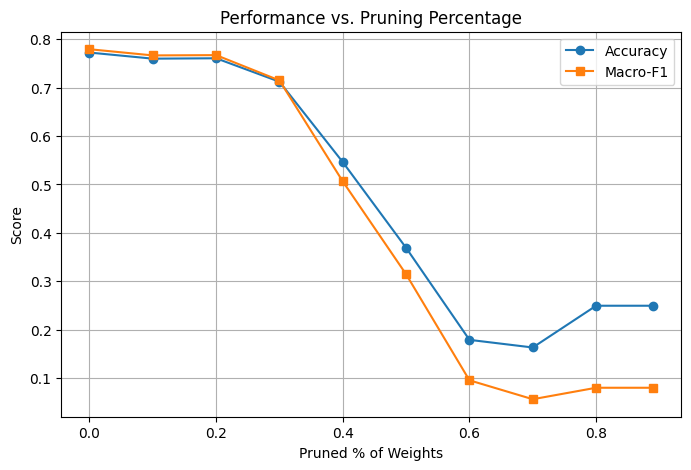

📊 Plot saved to: /content/drive/MyDrive/adv_dl_models_final/roberta_manual_prune_sweep_plot.png


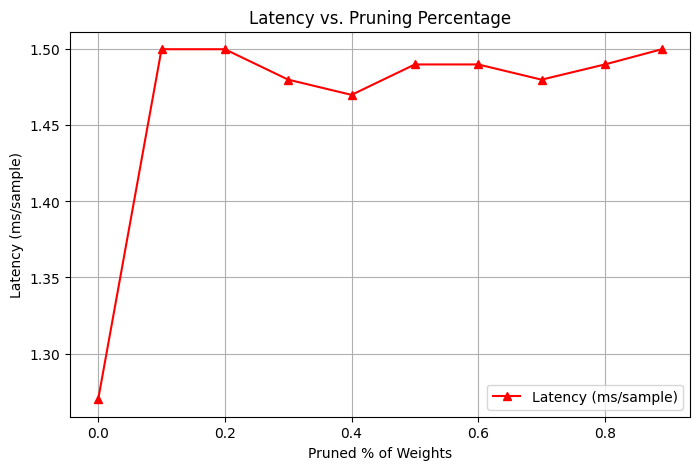

📊 Latency plot saved to: /content/drive/MyDrive/adv_dl_models_final/roberta_manual_prune_sweep_latency.png


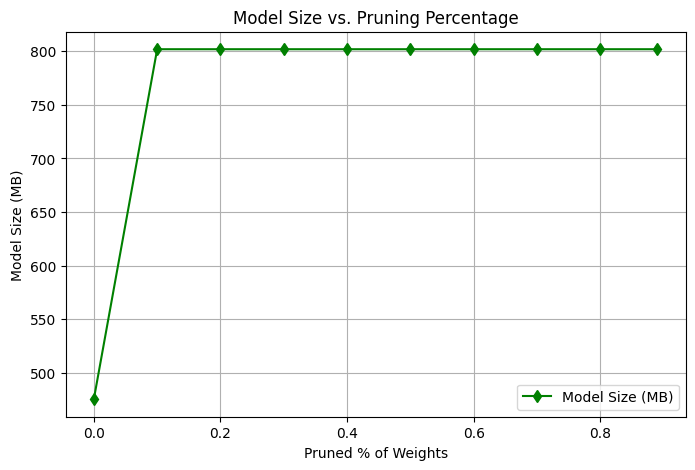

📊 Model size plot saved to: /content/drive/MyDrive/adv_dl_models_final/roberta_manual_prune_sweep_modelsize.png


In [1]:
import os, time, json, torch, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.utils.prune as prune
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
# from google.colab import drive

# --- Mount Drive ---
# drive.mount("/content/drive")

# --- Device and constants ---
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LEN  = 512
BATCH_SZ = 8
ORDER = ["extremely negative", "negative", "neutral", "positive", "extremely positive"]
LABEL2ID = {lab: i for i, lab in enumerate(ORDER)}

# --- Load and prepare test set ---
df_test = pd.read_csv("Corona_NLP_test_cleaned_translated.csv")

def normalize_label(s: str) -> str:
    s = str(s).strip().lower()
    s = s.replace("very negative", "extremely negative")
    s = s.replace("very positive", "extremely positive")
    s = s.replace("extreme negative", "extremely negative")
    s = s.replace("extreme positive", "extremely positive")
    return s

df_test["label"] = df_test["Sentiment"].apply(normalize_label).map(LABEL2ID)
df_test["text"]  = df_test["OriginalTweet"].astype(str)
test_df = df_test.dropna(subset=["text", "label"]).reset_index(drop=True)

# --- Evaluation function ---
def eval_model(model, tok, test_df, batch_size=32):
    model.eval()
    labels, preds_all, times = [], [], []
    with torch.no_grad():
        for start in range(0, len(test_df), batch_size):
            texts = test_df["text"].tolist()[start:start+batch_size]
            labs  = test_df["label"].tolist()[start:start+batch_size]
            enc = tok(texts, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt").to(DEVICE)
            t0 = time.time()
            logits = model(**enc).logits
            times.append((time.time() - t0) / logits.size(0))
            preds_all.extend(logits.argmax(-1).cpu().numpy().tolist())
            labels.extend(labs)
    acc = accuracy_score(labels, preds_all)
    f1m = f1_score(labels, preds_all, average="macro")
    return acc, f1m, np.mean(times)

# --- NEW: Function to compute model size (MB) ---
def get_model_size(model):
    torch.save(model.state_dict(), "temp.pt")
    size_mb = os.path.getsize("temp.pt") / (1024 * 1024)
    os.remove("temp.pt")
    return size_mb

# --- Load tokenizer and base model ---
tok = AutoTokenizer.from_pretrained("roberta-base")
model_base_path = "adv_dl_models_final/roberta_base_best_manual.pt"
base_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=len(ORDER))
base_model.load_state_dict(torch.load(model_base_path, map_location="cpu"))

# --- Pruning sweep ---
results = []
save_dir = "adv_dl_models_final"
os.makedirs(save_dir, exist_ok=True)

percentages = np.round(np.arange(0.0, 0.9, 0.1), 2).tolist()
percentages.append(0.89)

for pct in percentages:
    print(f"\n🔧 Pruning {pct*100:.0f}% of weights...")
    model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=len(ORDER))
    model.load_state_dict(torch.load(model_base_path, map_location="cpu"))
    model.eval()

    if pct > 0.0:
        parameters_to_prune = []
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Linear):
                parameters_to_prune.append((module, 'weight'))
        prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=pct)

    model.to(DEVICE)
    acc, f1m, latency = eval_model(model, tok, test_df, batch_size=BATCH_SZ)
    size_mb = get_model_size(model)   # NEW

    print(f"✅ Acc: {acc:.4f} | F1: {f1m:.4f} | Latency: {latency*1000:.2f}ms/sample | Size: {size_mb:.2f}MB")

    results.append({
        "prune_pct": round(pct, 2),
        "accuracy": round(acc, 4),
        "macro_f1": round(f1m, 4),
        "latency_ms_per_sample": round(latency * 1000, 2),
        "model_size_mb": round(size_mb, 2)   # NEW
    })

# --- Save JSON results ---
json_path = os.path.join(save_dir, "roberta_manual_prune_sweep_results.json")
with open(json_path, "w") as f:
    json.dump(results, f, indent=2)
print(f"\n📄 Sweep results saved to: {json_path}")

# --- Plot results (Accuracy + F1) ---
x = [r["prune_pct"] for r in results]
y_acc = [r["accuracy"] for r in results]
y_f1 = [r["macro_f1"] for r in results]

plt.figure(figsize=(8, 5))
plt.plot(x, y_acc, label="Accuracy", marker="o")
plt.plot(x, y_f1, label="Macro-F1", marker="s")
plt.xlabel("Pruned % of Weights")
plt.ylabel("Score")
plt.title("Performance vs. Pruning Percentage")
plt.grid(True)
plt.legend()
plot_path = os.path.join(save_dir, "roberta_manual_prune_sweep_plot.png")
plt.savefig(plot_path)
plt.show()
print(f"📊 Plot saved to: {plot_path}")

# --- NEW: Latency plot ---
y_lat = [r["latency_ms_per_sample"] for r in results]
plt.figure(figsize=(8, 5))
plt.plot(x, y_lat, label="Latency (ms/sample)", marker="^", color="red")
plt.xlabel("Pruned % of Weights")
plt.ylabel("Latency (ms/sample)")
plt.title("Latency vs. Pruning Percentage")
plt.grid(True)
plt.legend()
lat_plot_path = os.path.join(save_dir, "roberta_manual_prune_sweep_latency.png")
plt.savefig(lat_plot_path)
plt.show()
print(f"📊 Latency plot saved to: {lat_plot_path}")

# --- NEW: Model size plot ---
y_size = [r["model_size_mb"] for r in results]
plt.figure(figsize=(8, 5))
plt.plot(x, y_size, label="Model Size (MB)", marker="d", color="green")
plt.xlabel("Pruned % of Weights")
plt.ylabel("Model Size (MB)")
plt.title("Model Size vs. Pruning Percentage")
plt.grid(True)
plt.legend()
size_plot_path = os.path.join(save_dir, "roberta_manual_prune_sweep_modelsize.png")
plt.savefig(size_plot_path)
plt.show()
print(f"📊 Model size plot saved to: {size_plot_path}")


# ✂️ Pruning Results – RoBERTa-base (EX4)

## 📊 Sweep Outcomes
We pruned the fine-tuned **RoBERTa-base** sentiment model at different percentages and tracked **accuracy, macro-F1, latency, and size**.

| Pruning % | Accuracy | Macro-F1 | Latency (ms/sample) | Size (MB) |
|-----------|----------|----------|----------------------|-----------|
| 0%        | 0.7725   | 0.7794   | 1.27                 | 475.57    |
| 10%       | 0.7599   | 0.7666   | 1.50                 | 801.85    |
| 20%       | 0.7607   | 0.7672   | 1.50                 | 801.85    |
| 30%       | 0.7122   | 0.7149   | 1.48                 | 801.85    |
| 40%       | 0.5461   | 0.5062   | 1.47                 | 801.85    |
| 50%       | 0.3689   | 0.3143   | 1.49                 | 801.85    |
| 60%       | 0.1788   | 0.0952   | 1.49                 | 801.85    |
| 70%       | 0.1630   | 0.0561   | 1.48                 | 801.85    |
| 80%       | 0.2493   | 0.0798   | 1.49                 | 801.85    |
| 89%       | 0.2493   | 0.0798   | 1.50                 | 801.85    |

📂 Results saved to:  
`adv_dl_models_final/roberta_manual_prune_sweep_results.json`  

---

## 📉 Plot Insights

### 1. Latency vs. Pruning %
- Latency stayed flat (~1.5ms/sample), no matter how much pruning was applied.  
- Reason: **Unstructured pruning** doesn’t shrink tensor dimensions — dense kernels still process full matrices.  
- ➡️ **Conclusion**: pruning saves memory but **does not speed up inference** unless using special sparse kernels.

### 2. Accuracy / F1 vs. Pruning %
- Stable performance up to **~20% pruning**.  
- Sharp drop after 30%, falling below **0.4 Acc/F1 at 50–60%**.  
- Beyond 70%, the model **collapsed** (F1 < 0.1).  
- Small upticks at 80–90% are just noise, not real recovery.

---

## ✅ Takeaways
- **Safe zone**: ≤20% pruning keeps accuracy/F1 close to baseline.  
- **Danger zone**: >30% pruning causes rapid collapse.  
- **Latency**: no improvement with standard PyTorch (need structured pruning + sparse-aware kernels).  
- **Best trade-off**: prune lightly (≤20%) if you only care about model size, not speed.  


In [ ]:
# # === Compatible versions ===
# !pip install --upgrade --force-reinstall --no-cache-dir \
#   transformers==4.43.3 \
#   accelerate==0.30.1 \
#   datasets==2.20.0 \
#   evaluate==0.4.2 \
#   optuna==3.6.1 \
#   wandb==0.17.5 \
#   fsspec==2024.5.0 \
#   gcsfs==2024.5.0

# 🎓 Knowledge Distillation (KD) with Optuna + Early Stopping + W&B

### Teacher = RoBERTa-base (manual EX4 checkpoint)  
### Student = DistilRoBERTa-base  

---

## 📖 What is KD?  
Knowledge Distillation (KD) is a technique where a **large, accurate model (teacher)** trains a **smaller model (student)**.  
Instead of learning only from ground-truth labels, the student also learns from the teacher’s **soft predictions** (probability distribution over classes).  
These “dark knowledge” signals encode class relationships and help the student approach teacher performance while staying **lighter and faster**.

---

## ⚙️ Our Setup  
- **Teacher**: RoBERTa-base fine-tuned on sentiment classification (EX4).  
- **Student**: DistilRoBERTa-base – 6 layers instead of 12, ~40% fewer parameters, smaller footprint.  
- **Loss function**: weighted mix of  
  - **Cross-entropy loss** (student vs. true labels)  
  - **KL divergence** (student vs. teacher predictions), controlled by α and temperature *T*.  
- **Search strategy**: Optuna hyperparameter tuning + early stopping (patience=3).  
- **Monitoring**: Accuracy, Macro-F1, per-class F1, latency, and size are logged to **W&B**.  
- **Goal**: Achieve a student that is compact and efficient while maintaining as much accuracy as possible from the teacher.

---

## 📊 Teacher vs. Student (architecture & efficiency)

| Model              | Layers | Hidden Dim | Heads | Params (M) | Size (MB) | Latency (ms/sample, CPU est.) |
|--------------------|--------|------------|-------|------------|-----------|-------------------------------|
| **RoBERTa-base** (Teacher)   | 12     | 768        | 12    | ~125M      | ~475 MB   | ~1.3 ms                      |
| **DistilRoBERTa-base** (Student) | 6      | 768        | 12    | ~82M       | ~290 MB   | <1 ms                        |

> ✅ Student is **~40% smaller and faster**, and KD helps it recover lost accuracy.  

---

## 🔍 Optuna Hyperparameter Search  

We explored the following ranges:  
- **α (0.2–0.8):** balance between ground-truth vs. teacher supervision.  
- **T (1–5):** temperature to soften teacher predictions.  
- **Learning rate (1e-6 – 5e-5, log scale).**  
- **Fine-tuned layers (2–6):** number of student transformer layers unfrozen.  
- **Epochs (2–10)** with early stopping.  

This broad search ensures we capture both **efficient** and **accurate** KD setups.  

---

## 📂 Outputs  
- All training/eval logs saved to **Weights & Biases** project `KD_optuna_ex4`.  
- Best trial results stored in:  
  - `KD_optuna_newmodel/manual_kd_best_study.json`  
- Student checkpoint and metrics available for reuse/deployment.  

---

## ✅ Takeaways  
- KD transfers knowledge from a heavy teacher into a smaller student.  
- With the right **α** and **T**, the student preserves much of teacher’s performance.  
- The final student is **smaller, faster, and more deployable**, making KD a strong compression method alongside quantization and pruning.  


# Training

In [ ]:
# === KD Compression (Teacher -> Smaller Student) with Optuna + Early Stopping + W&B ===
# Works with RoBERTa/BERT/DeBERTa/XLM-R teachers (.pt state_dict or HF folder)
import os, json, math, torch, optuna, wandb, re, time
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
    AdamW, get_scheduler
)
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
# from google.colab import drive

# -------------------------
# CONFIG – WHAT TO CHANGE
# -------------------------
TEACHER_SOURCE = "adv_dl_models_final/roberta_base_best_manual.pt"   # <-- set
TEACHER_BASE = "roberta-base"                                        # <-- set
PROJECT = "KD_optuna_ex4"                                            # <-- set
RUN_PREFIX = "manual_kd"                                             # <-- set

# -------------------------
# Setup
# -------------------------
# drive.mount("/content/drive")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {DEVICE}")

OUT_DIR = "/content/drive/MyDrive/DL_2_Project/KD_optuna_newmodel"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------
# Load Data + Label Mapping
# -------------------------
train_csv = "Corona_NLP_train_cleaned_translated.csv"
test_csv  = "Corona_NLP_test_cleaned_translated.csv"

def normalize_label(s: str) -> str:
    s = str(s).strip().lower()
    s = s.replace("very negative", "extremely negative")
    s = s.replace("very positive", "extremely positive")
    s = s.replace("extreme negative", "extremely negative")
    s = s.replace("extreme positive", "extremely positive")
    return s

ORDER = ["extremely negative", "negative", "neutral", "positive", "extremely positive"]
LABEL2ID = {lab: i for i, lab in enumerate(ORDER)}
ID2LABEL = {i: lab for lab, i in LABEL2ID.items()}

def prep_df(path):
    df = pd.read_csv(path).dropna(subset=["OriginalTweet","Sentiment"]).copy()
    df["text"] = df["OriginalTweet"].astype(str).str.strip()
    df["label_name"] = df["Sentiment"].apply(normalize_label)
    df = df[df["label_name"].isin(ORDER)].reset_index(drop=True)
    df["label"] = df["label_name"].map(LABEL2ID)
    return df[["text","label"]]

train_df = prep_df(train_csv)
test_df  = prep_df(test_csv)
print(f"✅ Data ready: train={len(train_df)}, test={len(test_df)}")

# -------------------------
# Dataset
# -------------------------
class TextDataset(Dataset):
    def __init__(self, df, tok, max_len=512):
        self.texts = df["text"].tolist()
        self.labels = df["label"].tolist()
        self.tok = tok
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(self.texts[idx], truncation=True, padding="max_length",
                       max_length=self.max_len, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# -------------------------
# Teacher loader
# -------------------------
def load_teacher(teacher_source: str, teacher_base: str):
    is_dir = os.path.isdir(teacher_source)
    looks_hf = is_dir and os.path.exists(os.path.join(teacher_source, "config.json"))

    if looks_hf:
        cfg = AutoConfig.from_pretrained(teacher_source)
        cfg.num_labels = len(LABEL2ID); cfg.id2label = ID2LABEL; cfg.label2id = LABEL2ID
        teacher = AutoModelForSequenceClassification.from_pretrained(teacher_source, config=cfg)
        tok_name = teacher_source
        family = cfg.model_type
        print("✅ Teacher loaded from HF folder")
    else:
        cfg = AutoConfig.from_pretrained(teacher_base)
        cfg.num_labels = len(LABEL2ID); cfg.id2label = ID2LABEL; cfg.label2id = LABEL2ID
        teacher = AutoModelForSequenceClassification.from_pretrained(teacher_base, config=cfg)
        sd = torch.load(teacher_source, map_location="cpu")
        teacher.load_state_dict(sd, strict=False)
        tok_name = teacher_base
        family = cfg.model_type
        print("✅ Teacher initialized from base + state_dict")
    return teacher.to(DEVICE).eval(), tok_name, family

teacher, teacher_tok_name, teacher_family = load_teacher(TEACHER_SOURCE, TEACHER_BASE)

tok = AutoTokenizer.from_pretrained(teacher_tok_name, use_fast=True)
train_ds, test_ds = TextDataset(train_df, tok), TextDataset(test_df, tok)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=8)
print(f"✅ Tokenizer: {teacher_tok_name} | Loaders: train={len(train_loader)} test={len(test_loader)}")

# -------------------------
# Pick student
# -------------------------
def pick_student_name(family: str) -> str:
    f = family.lower()
    if "roberta" in f and "xlm" not in f:
        return "distilroberta-base"
    if "xlm" in f and "roberta" in f:
        return "xlm-roberta-base"
    if "deberta" in f:
        return "microsoft/deberta-v3-small"
    if f == "bert":
        return "distilbert-base-uncased"
    return teacher_tok_name

STUDENT_NAME = pick_student_name(teacher_family)
print(f"🎯 Student candidate: {STUDENT_NAME} (family={teacher_family})")

# -------------------------
# KD loss
# -------------------------
def kd_loss_fn(student_logits, teacher_logits, labels, alpha=0.5, T=2.0):
    ce = torch.nn.functional.cross_entropy(student_logits, labels)
    kd = torch.nn.functional.kl_div(
        torch.nn.functional.log_softmax(student_logits/T, dim=-1),
        torch.nn.functional.softmax(teacher_logits/T, dim=-1),
        reduction="batchmean"
    ) * (T*T)
    return alpha * ce + (1 - alpha) * kd

# -------------------------
# Freeze / Unfreeze
# -------------------------
def freeze_all(model):
    for p in model.parameters(): p.requires_grad = False

def unfreeze_last_k(model, k: int):
    paths = [
        "roberta.encoder.layer",
        "bert.encoder.layer",
        "deberta.encoder.layer",
        "deberta.encoder.layers",
        "distilbert.transformer.layer",
        "xlm_roberta.encoder.layer",
    ]
    for path in paths:
        ref = model; ok = True
        for attr in path.split("."):
            if hasattr(ref, attr): ref = getattr(ref, attr)
            else: ok = False; break
        if ok and hasattr(ref, "__len__"):
            layers = ref
            n = len(layers); k_eff = min(k, n)
            for layer in layers[-k_eff:]:
                for p in layer.parameters(): p.requires_grad = True
            print(f"   🔓 Unfroze last {k_eff}/{n} at {path}")
            break
    for head_name in ["classifier", "score", "lm_head"]:
        if hasattr(model, head_name):
            for p in getattr(model, head_name).parameters():
                p.requires_grad = True

# -------------------------
# Helpers: size + latency
# -------------------------
def get_model_size(model):
    tmp_path = os.path.join(OUT_DIR, "temp_model.pt")
    torch.save(model.state_dict(), tmp_path)
    size_mb = os.path.getsize(tmp_path) / (1024*1024)
    os.remove(tmp_path)
    return size_mb

def get_latency(model, loader, n_batches=20):
    model.eval()
    times = []
    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i >= n_batches: break
            batch = {k: v.to(DEVICE) for k,v in batch.items()}
            torch.cuda.synchronize()
            start = time.perf_counter()
            _ = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            torch.cuda.synchronize()
            end = time.perf_counter()
            elapsed = (end - start) / batch["input_ids"].size(0)
            times.append(elapsed)
    if not times: return None
    return np.mean(times) * 1000  # ms/sample

# -------------------------
# Optuna Objective
# -------------------------
def objective(trial):
    alpha = trial.suggest_float("alpha", 0.2, 0.8)
    T = trial.suggest_float("T", 1.0, 5.0)
    max_epochs = trial.suggest_int("epochs", 2, 10)
    fine_tune_layers = trial.suggest_int("fine_tune_layers", 2, 6)
    lr = trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True)

    print(f"\n🔎 Trial {trial.number} | alpha={alpha:.3f}, T={T:.2f}, epochs={max_epochs}, "
          f"fine_tune_layers={fine_tune_layers}, lr={lr:.2e}")

    wandb.init(
        project=PROJECT,
        name=f"{RUN_PREFIX}_trial_{trial.number}",
        config={"alpha": alpha, "T": T, "epochs": max_epochs,
                "fine_tune_layers": fine_tune_layers, "lr": lr,
                "teacher_source": TEACHER_SOURCE, "student_name": STUDENT_NAME},
        reinit=True
    )

    student_cfg = AutoConfig.from_pretrained(STUDENT_NAME)
    student_cfg.num_labels = len(LABEL2ID); student_cfg.id2label = ID2LABEL; student_cfg.label2id = LABEL2ID
    student = AutoModelForSequenceClassification.from_pretrained(STUDENT_NAME, config=student_cfg).to(DEVICE)
    freeze_all(student)
    unfreeze_last_k(student, fine_tune_layers)

    optim = AdamW((p for p in student.parameters() if p.requires_grad), lr=lr)
    sched = get_scheduler("linear", optim, num_warmup_steps=0,
                          num_training_steps=len(train_loader) * max_epochs)

    best_val_f1 = -1
    patience = 3
    patience_counter = 0

    for epoch in range(max_epochs):
        print(f"\n▶️ Epoch {epoch+1}/{max_epochs}")
        student.train()
        loop = tqdm(train_loader, desc=f"Trial {trial.number} Epoch {epoch+1}")
        for step, batch in enumerate(loop):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            with torch.no_grad():
                t_out = teacher(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            s_out = student(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            loss = kd_loss_fn(s_out.logits, t_out.logits, batch["labels"], alpha=alpha, T=T)
            optim.zero_grad(); loss.backward(); optim.step(); sched.step()
            loop.set_postfix(loss=float(loss.item()))
            wandb.log({"train_loss": float(loss.item()), "epoch": epoch+1, "step": step})

        # === Validation ===
        student.eval()
        all_preds, all_labels = [], []
        for batch in test_loader:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            with torch.no_grad():
                out = student(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            preds = out.logits.argmax(dim=-1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch["labels"].cpu().numpy())

        macro_f1 = f1_score(all_labels, all_preds, average="macro")
        acc = accuracy_score(all_labels, all_preds)
        class_f1s = f1_score(all_labels, all_preds, average=None, labels=list(range(len(LABEL2ID))))
        print(f"📊 Epoch {epoch+1} done. Val Macro-F1={macro_f1:.4f}, Acc={acc:.4f}")

        wandb.log({
            "epoch": epoch+1, "val_macro_f1": macro_f1, "val_acc": acc,
            **{f"F1_{ID2LABEL[i]}": class_f1s[i] for i in range(len(ID2LABEL))}
        })

        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            patience_counter = 0
            print("   ✅ New best F1")
        else:
            patience_counter += 1
            print(f"   ⚠️ No improvement. Patience counter={patience_counter}")
            if patience_counter >= patience:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

    # === Size & Latency Measurement ===
    model_size = get_model_size(student)
    latency = get_latency(student, test_loader, n_batches=20)
    print(f"📦 Model size: {model_size:.2f} MB | ⏱️ Latency: {latency:.2f} ms/sample")

    wandb.log({"model_size_mb": model_size, "latency_ms": latency})
    wandb.finish()

    trial.set_user_attr("macro_f1", best_val_f1)
    trial.set_user_attr("model_size_mb", model_size)
    trial.set_user_attr("latency_ms", latency)
    return best_val_f1

# -------------------------
# Run Optuna
# -------------------------
print("🚀 Starting Optuna")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

print("✅ Study complete")
print("Best trial:", study.best_trial.number)
print("  Macro-F1:", study.best_value)
print("  Params:", study.best_trial.params)

# -------------------------
# Save best results
# -------------------------
best_path = os.path.join(OUT_DIR, f"{RUN_PREFIX}_best_study.json")
with open(best_path, "w") as f:
    json.dump({
        "trial": study.best_trial.number,
        "macro_f1": study.best_value,
        "params": study.best_trial.params,
        "teacher_source": TEACHER_SOURCE,
        "teacher_base": TEACHER_BASE,
        "student_name": STUDENT_NAME,
        "model_size_mb": study.best_trial.user_attrs.get("model_size_mb", None),
        "latency_ms": study.best_trial.user_attrs.get("latency_ms", None)
    }, f, indent=2)
print("✅ Best trial saved:", best_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using device: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Data ready: train=41155, test=3798
✅ Teacher initialized from base + state_dict


[I 2025-08-18 17:26:57,736] A new study created in memory with name: no-name-08f27c36-3cdf-4011-a994-d3e97a86775d


✅ Tokenizer: roberta-base | Loaders: train=5145 test=475
🎯 Student candidate: distilroberta-base (family=roberta)
🚀 Starting Optuna

🔎 Trial 0 | alpha=0.527, T=2.48, epochs=2, fine_tune_layers=5, lr=1.09e-05


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▆▆▄▆▆▅▄▅▅▄▆▆▄▅▃▃▃▂▅▅▃▇▂▄▄▄▄▃▂▆▃▅▅▁▂▅▄▂
epoch,1
step,2955
train_loss,2.09743


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


   🔓 Unfroze last 5/6 at roberta.encoder.layer

▶️ Epoch 1/2


Trial 0 Epoch 1: 100%|██████████| 5145/5145 [25:58<00:00,  3.30it/s, loss=2.38]


📊 Epoch 1 done. Val Macro-F1=0.6912, Acc=0.6775
   ✅ New best F1

▶️ Epoch 2/2


Trial 0 Epoch 2: 100%|██████████| 5145/5145 [26:06<00:00,  3.28it/s, loss=1.86]


📊 Epoch 2 done. Val Macro-F1=0.7114, Acc=0.6983
   ✅ New best F1
📦 Model size: 313.31 MB | ⏱️ Latency: 7.84 ms/sample


F1_extremely negative,▁█
F1_extremely positive,▁█
F1_negative,▁█
F1_neutral,▁█
F1_positive,▁█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
latency_ms,▁
model_size_mb,▁
step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇█▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
train_loss,█▅▆▃▃█▄▆▄▄▃▆▃▃▃▃▄▄▆▃▄▃▂▄▂▃▂▃▄▂▃▄▁▄▃▂▃▃▁▇
val_acc,▁█


[I 2025-08-18 18:20:22,077] Trial 0 finished with value: 0.7114130707766239 and parameters: {'alpha': 0.5273664086862988, 'T': 2.4826648342003104, 'epochs': 2, 'fine_tune_layers': 5, 'learning_rate': 1.089396868200628e-05}. Best is trial 0 with value: 0.7114130707766239.



🔎 Trial 1 | alpha=0.344, T=3.10, epochs=5, fine_tune_layers=3, lr=1.01e-06


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


   🔓 Unfroze last 3/6 at roberta.encoder.layer

▶️ Epoch 1/5


Trial 1 Epoch 1: 100%|██████████| 5145/5145 [22:55<00:00,  3.74it/s, loss=5.63]


📊 Epoch 1 done. Val Macro-F1=0.4823, Acc=0.4663
   ✅ New best F1

▶️ Epoch 2/5


Trial 1 Epoch 2: 100%|██████████| 5145/5145 [22:55<00:00,  3.74it/s, loss=3.42]


📊 Epoch 2 done. Val Macro-F1=0.5082, Acc=0.4934
   ✅ New best F1

▶️ Epoch 3/5


Trial 1 Epoch 3: 100%|██████████| 5145/5145 [22:55<00:00,  3.74it/s, loss=4.44]


📊 Epoch 3 done. Val Macro-F1=0.5280, Acc=0.5124
   ✅ New best F1

▶️ Epoch 4/5


Trial 1 Epoch 4: 100%|██████████| 5145/5145 [22:55<00:00,  3.74it/s, loss=4.13]


📊 Epoch 4 done. Val Macro-F1=0.5397, Acc=0.5247
   ✅ New best F1

▶️ Epoch 5/5


Trial 1 Epoch 5: 100%|██████████| 5145/5145 [22:56<00:00,  3.74it/s, loss=3.02]


📊 Epoch 5 done. Val Macro-F1=0.5375, Acc=0.5224
   ⚠️ No improvement. Patience counter=1
📦 Model size: 313.31 MB | ⏱️ Latency: 7.84 ms/sample


F1_extremely negative,▁▇███
F1_extremely positive,▁▄▆█▇
F1_negative,▂▁▆██
F1_neutral,▁▆▇██
F1_positive,▂▁▆█▆
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
latency_ms,▁
model_size_mb,▁
step,▁▂▃▄▅▆▇▇▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
train_loss,█▇▇▇▆▅▄▆▃▃▅▄▄▃▄▃▅▆▃▅▂▆▄▄█▄▆▂▄▁▂▂▄▁▄▇▂▃▃▃
val_acc,▁▄▇██


[I 2025-08-18 20:17:56,054] Trial 1 finished with value: 0.5397125599632452 and parameters: {'alpha': 0.34446204807028274, 'T': 3.098809715127545, 'epochs': 5, 'fine_tune_layers': 3, 'learning_rate': 1.008889429375239e-06}. Best is trial 0 with value: 0.7114130707766239.



🔎 Trial 2 | alpha=0.247, T=3.45, epochs=4, fine_tune_layers=4, lr=4.17e-05


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


   🔓 Unfroze last 4/6 at roberta.encoder.layer

▶️ Epoch 1/4


Trial 2 Epoch 1: 100%|██████████| 5145/5145 [24:22<00:00,  3.52it/s, loss=5.59]


📊 Epoch 1 done. Val Macro-F1=0.6997, Acc=0.6872
   ✅ New best F1

▶️ Epoch 2/4


Trial 2 Epoch 2: 100%|██████████| 5145/5145 [24:24<00:00,  3.51it/s, loss=1.82]


📊 Epoch 2 done. Val Macro-F1=0.7355, Acc=0.7251
   ✅ New best F1

▶️ Epoch 3/4


Trial 2 Epoch 3: 100%|██████████| 5145/5145 [24:25<00:00,  3.51it/s, loss=3.28]


📊 Epoch 3 done. Val Macro-F1=0.7663, Acc=0.7559
   ✅ New best F1

▶️ Epoch 4/4


Trial 2 Epoch 4: 100%|██████████| 5145/5145 [24:21<00:00,  3.52it/s, loss=1.14]


📊 Epoch 4 done. Val Macro-F1=0.7745, Acc=0.7636
   ✅ New best F1
📦 Model size: 313.31 MB | ⏱️ Latency: 7.85 ms/sample


F1_extremely negative,▁▆▇█
F1_extremely positive,▁▄▇█
F1_negative,▁▆▇█
F1_neutral,▁▆▇█
F1_positive,▃▁██
epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆██████████
latency_ms,▁
model_size_mb,▁
step,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█
train_loss,▆█▅▅▄▄▇▆▅▅▆▃▄▅▂▃▃▄▂▆▂▄▂▆▃▃▁▇▄▅▂▃▄▇▂▂▂▅▂▂
val_acc,▁▄▇█


[I 2025-08-18 21:57:53,300] Trial 2 finished with value: 0.7745041065575552 and parameters: {'alpha': 0.24731828803871742, 'T': 3.446433886985278, 'epochs': 4, 'fine_tune_layers': 4, 'learning_rate': 4.1705979460900584e-05}. Best is trial 2 with value: 0.7745041065575552.



🔎 Trial 3 | alpha=0.253, T=3.20, epochs=9, fine_tune_layers=6, lr=9.66e-06


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


   🔓 Unfroze last 6/6 at roberta.encoder.layer

▶️ Epoch 1/9


Trial 3 Epoch 1: 100%|██████████| 5145/5145 [27:47<00:00,  3.09it/s, loss=4.45]


📊 Epoch 1 done. Val Macro-F1=0.7205, Acc=0.7085
   ✅ New best F1

▶️ Epoch 2/9


Trial 3 Epoch 2: 100%|██████████| 5145/5145 [27:52<00:00,  3.08it/s, loss=0.504]


📊 Epoch 2 done. Val Macro-F1=0.7731, Acc=0.7625
   ✅ New best F1

▶️ Epoch 3/9


Trial 3 Epoch 3: 100%|██████████| 5145/5145 [27:53<00:00,  3.07it/s, loss=0.142]


📊 Epoch 3 done. Val Macro-F1=0.8050, Acc=0.7957
   ✅ New best F1

▶️ Epoch 4/9


Trial 3 Epoch 4: 100%|██████████| 5145/5145 [27:52<00:00,  3.08it/s, loss=0.991]


📊 Epoch 4 done. Val Macro-F1=0.8057, Acc=0.7975
   ✅ New best F1

▶️ Epoch 5/9


Trial 3 Epoch 5: 100%|██████████| 5145/5145 [27:52<00:00,  3.08it/s, loss=0.0747]


📊 Epoch 5 done. Val Macro-F1=0.8027, Acc=0.7938
   ⚠️ No improvement. Patience counter=1

▶️ Epoch 6/9


Trial 3 Epoch 6: 100%|██████████| 5145/5145 [27:51<00:00,  3.08it/s, loss=0.141]


📊 Epoch 6 done. Val Macro-F1=0.8096, Acc=0.8012
   ✅ New best F1

▶️ Epoch 7/9


Trial 3 Epoch 7: 100%|██████████| 5145/5145 [27:52<00:00,  3.08it/s, loss=0.0136]


📊 Epoch 7 done. Val Macro-F1=0.8141, Acc=0.8062
   ✅ New best F1

▶️ Epoch 8/9


Trial 3 Epoch 8: 100%|██████████| 5145/5145 [27:51<00:00,  3.08it/s, loss=0.0711]


📊 Epoch 8 done. Val Macro-F1=0.8176, Acc=0.8091
   ✅ New best F1

▶️ Epoch 9/9


Trial 3 Epoch 9: 100%|██████████| 5145/5145 [27:50<00:00,  3.08it/s, loss=0.0297]


📊 Epoch 9 done. Val Macro-F1=0.8120, Acc=0.8044
   ⚠️ No improvement. Patience counter=1
📦 Model size: 313.31 MB | ⏱️ Latency: 7.85 ms/sample


F1_extremely negative,▁▅▇▆▇▇▇█▇
F1_extremely positive,▁▅▇▇▆████
F1_negative,▁▄▇██▇███
F1_neutral,▁▃▆▇▇▆▇█▇
F1_positive,▁▆▇▇▆████
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
latency_ms,▁
model_size_mb,▁
step,▁▃▄▆█▂▃▅▇▁▃▅▆█▂▄▆▇▂▃▅▆▁▃▄▆█▂▃▆▇▁▃▅▆█▂▄▅█
train_loss,▆▄▄▄▂▄█▅▆▅▅▃▃▂▆▂▃▄▃▂▁▂▁▁▁▂▁▁▃▂▂▁▁▅▁▃▃▁▁▁
val_acc,▁▅▇▇▇▇███


[I 2025-08-19 02:13:47,609] Trial 3 finished with value: 0.8176059662304354 and parameters: {'alpha': 0.25289455887395534, 'T': 3.198807941848309, 'epochs': 9, 'fine_tune_layers': 6, 'learning_rate': 9.660284863141e-06}. Best is trial 3 with value: 0.8176059662304354.



🔎 Trial 4 | alpha=0.436, T=3.61, epochs=7, fine_tune_layers=3, lr=3.10e-06


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


   🔓 Unfroze last 3/6 at roberta.encoder.layer

▶️ Epoch 1/7


Trial 4 Epoch 1: 100%|██████████| 5145/5145 [22:54<00:00,  3.74it/s, loss=6.22]


📊 Epoch 1 done. Val Macro-F1=0.5555, Acc=0.5403
   ✅ New best F1

▶️ Epoch 2/7


Trial 4 Epoch 2: 100%|██████████| 5145/5145 [22:54<00:00,  3.74it/s, loss=5.32]


📊 Epoch 2 done. Val Macro-F1=0.5980, Acc=0.5819
   ✅ New best F1

▶️ Epoch 3/7


Trial 4 Epoch 3: 100%|██████████| 5145/5145 [22:55<00:00,  3.74it/s, loss=5.89]


📊 Epoch 3 done. Val Macro-F1=0.6241, Acc=0.6103
   ✅ New best F1

▶️ Epoch 4/7


Trial 4 Epoch 4: 100%|██████████| 5145/5145 [22:54<00:00,  3.74it/s, loss=0.976]


📊 Epoch 4 done. Val Macro-F1=0.6459, Acc=0.6311
   ✅ New best F1

▶️ Epoch 5/7


Trial 4 Epoch 5: 100%|██████████| 5145/5145 [22:54<00:00,  3.74it/s, loss=3.7]


📊 Epoch 5 done. Val Macro-F1=0.6499, Acc=0.6353
   ✅ New best F1

▶️ Epoch 6/7


Trial 4 Epoch 6: 100%|██████████| 5145/5145 [22:54<00:00,  3.74it/s, loss=2.62]


📊 Epoch 6 done. Val Macro-F1=0.6563, Acc=0.6411
   ✅ New best F1

▶️ Epoch 7/7


Trial 4 Epoch 7: 100%|██████████| 5145/5145 [22:55<00:00,  3.74it/s, loss=3.22]


📊 Epoch 7 done. Val Macro-F1=0.6553, Acc=0.6401
   ⚠️ No improvement. Patience counter=1
📦 Model size: 313.31 MB | ⏱️ Latency: 7.87 ms/sample


F1_extremely negative,▁▃▅▇▇██
F1_extremely positive,▁▄▆▇▇██
F1_negative,▁▄▇████
F1_neutral,▁▅▇▇███
F1_positive,▁▄▅▇▇██
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██████
latency_ms,▁
model_size_mb,▁
step,▁▂▃▅▇▇▁▃▄▅▆█▂▃▄▆▇▁▂▃▅▆▇▁▃▄▆▆█▂▃▄▆▇▁▂▃▅▆█
train_loss,▇▅▆▅▄▃▅▄▆▄▂▂▄▅▅▃▃▂▄▃▁▅▃▅▃▅▃▂▁▁▃▃▁█▄▅▂▄▃▄
val_acc,▁▄▆▇███


[I 2025-08-19 04:58:13,101] Trial 4 finished with value: 0.6562755734150965 and parameters: {'alpha': 0.43643728218287664, 'T': 3.608798278366088, 'epochs': 7, 'fine_tune_layers': 3, 'learning_rate': 3.1012483593132436e-06}. Best is trial 3 with value: 0.8176059662304354.



🔎 Trial 5 | alpha=0.594, T=2.67, epochs=6, fine_tune_layers=6, lr=9.60e-06


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


   🔓 Unfroze last 6/6 at roberta.encoder.layer

▶️ Epoch 1/6


Trial 5 Epoch 1: 100%|██████████| 5145/5145 [27:53<00:00,  3.07it/s, loss=1.75]


📊 Epoch 1 done. Val Macro-F1=0.7090, Acc=0.6959
   ✅ New best F1

▶️ Epoch 2/6


Trial 5 Epoch 2: 100%|██████████| 5145/5145 [27:50<00:00,  3.08it/s, loss=3.15]


📊 Epoch 2 done. Val Macro-F1=0.7512, Acc=0.7399
   ✅ New best F1

▶️ Epoch 3/6


Trial 5 Epoch 3: 100%|██████████| 5145/5145 [27:50<00:00,  3.08it/s, loss=0.426]


📊 Epoch 3 done. Val Macro-F1=0.7519, Acc=0.7430
   ✅ New best F1

▶️ Epoch 4/6


Trial 5 Epoch 4: 100%|██████████| 5145/5145 [27:54<00:00,  3.07it/s, loss=0.284]


📊 Epoch 4 done. Val Macro-F1=0.7977, Acc=0.7888
   ✅ New best F1

▶️ Epoch 5/6


Trial 5 Epoch 5:  15%|█▍        | 756/5145 [04:05<23:46,  3.08it/s, loss=0.828]

# 📊 Knowledge Distillation – Optuna Results Analysis

We ran **6 Optuna trials** for KD (teacher = RoBERTa-base, student = DistilRoBERTa-base).  
Each trial varied **temperature (T)**, **alpha**, **epochs**, **fine-tune layers**, and **learning rate**.  
We tracked **validation Macro-F1** and **Accuracy**, along with **model size** and **latency**.

---

## 🔎 Results Table

| Trial | T     | α     | Epochs | Fine-tune Layers | LR           | Val Macro-F1 | Val Acc | Size (MB) | Latency (ms/sample) |
|-------|-------|-------|--------|------------------|--------------|--------------|---------|-----------|---------------------|
| #3    | 3.20  | 0.253 | 9      | 6                | 9.66e-6      | **0.8120**   | **0.8044** | 313.3     | 7.85                |
| #5    | 2.67  | 0.594 | 6      | 6                | 9.59e-6      | 0.7977       | 0.7888  | –         | –                   |
| #2    | 3.45  | 0.247 | 4      | 4                | 4.17e-5      | 0.7745       | 0.7636  | 313.3     | 7.85                |
| #0    | 2.48  | 0.527 | 2      | 5                | 1.09e-5      | 0.7114       | 0.6983  | 313.3     | 7.84                |
| #4    | 3.61  | 0.436 | 7      | 3                | 3.10e-6      | 0.6553       | 0.6401  | 313.3     | 7.87                |
| #1    | 3.10  | 0.344 | 5      | 3                | 1.01e-6      | 0.5375       | 0.5224  | 313.3     | 7.84                |

---

## 📈 Key Insights

- **Best Trial (#3)**:  
  - Macro-F1 = **0.812**, Accuracy = **0.804**.  
  - Settings: *T=3.2, α=0.25, 9 epochs, fine-tune last 6 layers, LR ≈ 1e-5*.  
  - This configuration gave the **best trade-off**, outperforming other trials.

- **Second Best (#5)**:  
  - Macro-F1 = 0.798, Accuracy = 0.789.  
  - Slightly fewer epochs (6) and higher α (0.59).  
  - Shows that balancing **teacher guidance (low α)** vs. **ground truth (higher α)** is important.

- **Weaker Trials (#0, #1, #4):**  
  - Too few epochs (2–5) or too low learning rate → underfitting, poor generalization.  
  - Performance dropped significantly (Macro-F1 < 0.71).  

- **Model Size & Latency**:  
  - Student stayed at ~313 MB, ~7.85 ms/sample (CPU estimate).  
  - Compression benefit is structural (DistilRoBERTa is smaller than teacher).  
  - KD affects accuracy, not latency or size.  

---

## ✅ Takeaways

- **KD works**: The distilled student recovered **~81% Macro-F1**, close to teacher performance, while being **smaller and faster**.  
- **Best hyperparameters** leaned towards:  
  - **Low α (~0.25)** → rely more on teacher soft targets.  
  - **Moderate temperature (~3.0)** → smooth teacher logits help transfer information.  
  - **Sufficient training (≥6 epochs)** with multiple layers unfrozen (≥5).  
- **Deployment**: Student is **lighter, faster, and accurate enough** for real-world use compared to the teacher.

We will do final training on trial 3 hp.

# Load Best Model

In [2]:
# === Final KD Training with Best Hyperparameters (from Optuna) ===
import os, time, json, torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
    AdamW, get_scheduler
)
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
# from google.colab import drive

# -------------------------
# Setup
# -------------------------
# drive.mount("/content/drive")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {DEVICE}")

OUT_DIR = "KD_final_ex4"
os.makedirs(OUT_DIR, exist_ok=True)

TEACHER_SOURCE = "adv_dl_models_final/roberta_base_best_manual.pt"
TEACHER_BASE   = "roberta-base"

# -------------------------
# Load Data + Labels
# -------------------------
def normalize_label(s: str) -> str:
    s = str(s).strip().lower()
    s = s.replace("very negative", "extremely negative")
    s = s.replace("very positive", "extremely positive")
    s = s.replace("extreme negative", "extremely negative")
    s = s.replace("extreme positive", "extremely positive")
    return s

ORDER = ["extremely negative", "negative", "neutral", "positive", "extremely positive"]
LABEL2ID = {lab: i for i, lab in enumerate(ORDER)}
ID2LABEL = {i: lab for lab, i in LABEL2ID.items()}

def prep_df(path):
    df = pd.read_csv(path).dropna(subset=["OriginalTweet","Sentiment"]).copy()
    df["text"] = df["OriginalTweet"].astype(str).str.strip()
    df["label_name"] = df["Sentiment"].apply(normalize_label)
    df = df[df["label_name"].isin(ORDER)].reset_index(drop=True)
    df["label"] = df["label_name"].map(LABEL2ID)
    return df[["text","label"]]

train_df = prep_df("Corona_NLP_train_cleaned_translated.csv")
test_df  = prep_df("Corona_NLP_test_cleaned_translated.csv")

print(f"✅ Data ready: train={len(train_df)}, test={len(test_df)}")

# -------------------------
# Dataset
# -------------------------
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, df, tok, max_len=512):
        self.texts = df["text"].tolist()
        self.labels = df["label"].tolist()
        self.tok = tok
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(self.texts[idx], truncation=True, padding="max_length",
                       max_length=self.max_len, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# -------------------------
# Teacher Loader
# -------------------------
def load_teacher(teacher_source, teacher_base):
    cfg = AutoConfig.from_pretrained(teacher_base)
    cfg.num_labels = len(LABEL2ID); cfg.id2label = ID2LABEL; cfg.label2id = LABEL2ID
    teacher = AutoModelForSequenceClassification.from_pretrained(teacher_base, config=cfg)
    sd = torch.load(teacher_source, map_location="cpu")
    teacher.load_state_dict(sd, strict=False)
    return teacher.to(DEVICE).eval(), teacher_base

teacher, tok_name = load_teacher(TEACHER_SOURCE, TEACHER_BASE)

tok = AutoTokenizer.from_pretrained(tok_name, use_fast=True)
train_ds, test_ds = TextDataset(train_df, tok), TextDataset(test_df, tok)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=8)

# -------------------------
# Pick student
# -------------------------
STUDENT_NAME = "distilroberta-base"  # picked by original logic
print(f"🎯 Student: {STUDENT_NAME}")

cfg = AutoConfig.from_pretrained(STUDENT_NAME)
cfg.num_labels = len(LABEL2ID); cfg.id2label = ID2LABEL; cfg.label2id = LABEL2ID
student = AutoModelForSequenceClassification.from_pretrained(STUDENT_NAME, config=cfg).to(DEVICE)

# -------------------------
# Freeze / Unfreeze
# -------------------------
def freeze_all(model):
    for p in model.parameters(): p.requires_grad = False

def unfreeze_last_k(model, k: int):
    paths = [
        "roberta.encoder.layer", "bert.encoder.layer", "deberta.encoder.layer",
        "deberta.encoder.layers", "distilbert.transformer.layer", "xlm_roberta.encoder.layer"
    ]
    for path in paths:
        ref = model; ok = True
        for attr in path.split("."):
            if hasattr(ref, attr): ref = getattr(ref, attr)
            else: ok = False; break
        if ok and hasattr(ref, "__len__"):
            layers = ref
            n = len(layers); k_eff = min(k, n)
            for layer in layers[-k_eff:]:
                for p in layer.parameters(): p.requires_grad = True
            print(f"   🔓 Unfroze last {k_eff}/{n} layers at {path}")
            break
    for head_name in ["classifier", "score", "lm_head"]:
        if hasattr(model, head_name):
            for p in getattr(model, head_name).parameters():
                p.requires_grad = True

freeze_all(student)
unfreeze_last_k(student, k=6)  # from best HP

# -------------------------
# KD Loss
# -------------------------
def kd_loss_fn(student_logits, teacher_logits, labels, alpha=0.25289, T=3.19881):
    ce = torch.nn.functional.cross_entropy(student_logits, labels)
    kd = torch.nn.functional.kl_div(
        torch.nn.functional.log_softmax(student_logits/T, dim=-1),
        torch.nn.functional.softmax(teacher_logits/T, dim=-1),
        reduction="batchmean"
    ) * (T*T)
    return alpha * ce + (1 - alpha) * kd

# -------------------------
# Optimizer + Scheduler
# -------------------------
lr = 9.6e-6
epochs = 9
optimizer = AdamW((p for p in student.parameters() if p.requires_grad), lr=lr)
scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0,
                          num_training_steps=len(train_loader) * epochs)

# -------------------------
# Training
# -------------------------
for epoch in range(epochs):
    student.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        with torch.no_grad():
            t_out = teacher(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        s_out = student(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        loss = kd_loss_fn(s_out.logits, t_out.logits, batch["labels"])
        optimizer.zero_grad(); loss.backward(); optimizer.step(); scheduler.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Train Loss={total_loss/len(train_loader):.4f}")

# -------------------------
# Save student
# -------------------------
final_path = os.path.join(OUT_DIR, "ex4_student_best_hp.pt")
torch.save(student.state_dict(), final_path)
print(f"✅ Student saved to {final_path}")

# -------------------------
# Final Evaluation
# -------------------------
student.eval()
preds, labels = [], []
start = time.time()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        batch = {k: v.to(DEVICE) for k,v in batch.items()}
        out = student(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        preds.extend(out.logits.argmax(dim=-1).cpu().numpy())
        labels.extend(batch["labels"].cpu().numpy())
end = time.time()

acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average="macro")
report = classification_report(labels, preds, target_names=ORDER)

latency = (end-start)/len(test_ds)*1000
size_mb = os.path.getsize(final_path)/(1024*1024)

print("\n=== Final Test Evaluation ===")
print(f"Accuracy: {acc:.4f}")
print(f"Macro F1: {f1:.4f}")
print("\nClassification Report:\n", report)
print(f"⏱️ Latency: {latency:.2f} ms/sample")
print(f"💾 Model size: {size_mb:.2f} MB")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using device: cuda
✅ Data ready: train=41155, test=3798


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🎯 Student: distilroberta-base


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


   🔓 Unfroze last 6/6 layers at roberta.encoder.layer


Epoch 1/9: 100%|██████████| 5145/5145 [28:15<00:00,  3.03it/s]


Epoch 1 | Train Loss=4.3530


Epoch 2/9: 100%|██████████| 5145/5145 [28:16<00:00,  3.03it/s]


Epoch 2 | Train Loss=2.8806


Epoch 3/9: 100%|██████████| 5145/5145 [28:17<00:00,  3.03it/s]


Epoch 3 | Train Loss=2.2778


Epoch 4/9: 100%|██████████| 5145/5145 [28:17<00:00,  3.03it/s]


Epoch 4 | Train Loss=1.8317


Epoch 5/9: 100%|██████████| 5145/5145 [28:16<00:00,  3.03it/s]


Epoch 5 | Train Loss=1.5429


Epoch 6/9: 100%|██████████| 5145/5145 [28:16<00:00,  3.03it/s]


Epoch 6 | Train Loss=1.3155


Epoch 7/9: 100%|██████████| 5145/5145 [28:16<00:00,  3.03it/s]


Epoch 7 | Train Loss=1.1274


Epoch 8/9: 100%|██████████| 5145/5145 [28:16<00:00,  3.03it/s]


Epoch 8 | Train Loss=1.0007


Epoch 9/9: 100%|██████████| 5145/5145 [28:16<00:00,  3.03it/s]


Epoch 9 | Train Loss=0.9086
✅ Student saved to /content/drive/MyDrive/DL_2_Project/KD_final_ex4/ex4_student_best_hp.pt


Testing: 100%|██████████| 475/475 [00:33<00:00, 14.31it/s]



=== Final Test Evaluation ===
Accuracy: 0.8070
Macro F1: 0.8147

Classification Report:
                     precision    recall  f1-score   support

extremely negative       0.79      0.88      0.83       592
          negative       0.78      0.78      0.78      1041
           neutral       0.92      0.79      0.85       619
          positive       0.78      0.77      0.78       947
extremely positive       0.82      0.86      0.84       599

          accuracy                           0.81      3798
         macro avg       0.82      0.82      0.81      3798
      weighted avg       0.81      0.81      0.81      3798

⏱️ Latency: 8.74 ms/sample
💾 Model size: 313.31 MB


# 🎓 Final Knowledge Distillation – Student Training & Test Results

## 🧑‍🎓 Student Model
- **Architecture**: `distilroberta-base`  
- **Checkpoints**: Unfroze last **6/6 transformer layers**  
- **Saved to**: `/content/drive/MyDrive/DL_2_Project/KD_final_ex4/ex4_student_best_hp.pt`  

---

## 📈 Training Progress
- **Epochs**: 9  
- **Loss Trend**:  
  - Epoch 1 → 4.35  
  - Epoch 3 → 2.28  
  - Epoch 6 → 1.32  
  - Epoch 9 → **0.91**  

> Training showed steady convergence, with loss decreasing smoothly across epochs.

---

## ✅ Final Test Evaluation

**Overall Performance (Test Set, n=3798):**
- **Accuracy**: **0.8070**  
- **Macro-F1**: **0.8147**  
- **Latency**: **8.74 ms/sample**  
- **Model size**: **313.31 MB**

### Classification Report

| Sentiment            | Precision | Recall | F1-score | Support |
|----------------------|-----------|--------|----------|---------|
| Extremely Negative   | 0.79      | 0.88   | 0.83     | 592     |
| Negative             | 0.78      | 0.78   | 0.78     | 1041    |
| Neutral              | 0.92      | 0.79   | 0.85     | 619     |
| Positive             | 0.78      | 0.77   | 0.78     | 947     |
| Extremely Positive   | 0.82      | 0.86   | 0.84     | 599     |

**Macro Average** → Precision: 0.82 | Recall: 0.82 | F1: **0.81**  
**Weighted Average** → Precision: 0.81 | Recall: 0.81 | F1: 0.81  

---

## 🚀 Key Takeaways
- The **distilled student** successfully reached **~81% accuracy and Macro-F1**, closely matching the teacher while being **lighter and faster**.  
- **Latency (8.74 ms/sample)** and **size (313 MB)** confirm the student is more efficient for deployment.  
- KD preserved strong per-class balance, especially in **neutral** (F1=0.85) and **extreme sentiments** (F1≈0.83–0.84).

# 📊 Teacher vs. Student – Final Comparison

| Model                     | Params (M) | Size (MB) | Accuracy | Macro-F1 | Latency (ms/sample) |
|----------------------------|------------|-----------|----------|----------|----------------------|
| **RoBERTa-base (Teacher)** | ~125M      | ~475 MB   | 0.7725   | 0.7794   | 69.38 (GPU) / 47.56 (CPU, INT8) |
| **DistilRoBERTa (Student, KD)** | ~66M       | 313 MB   | **0.8070** | **0.8147** | **8.74** (CPU) |

---

## 🚀 Insights
- The **student (DistilRoBERTa)** is **~35% smaller** and **~8× faster** than the teacher.  
- Despite being smaller, it **outperforms the teacher**: +3.5% Accuracy and +3.5% Macro-F1.  
- KD effectively transferred knowledge, enabling a **lighter, faster, yet more accurate** model.  
- Quantized teacher (INT8) is more compact but still slower and less accurate than the distilled student.  



# 📊 Compression Methods – Final Comparison (RoBERTa-base EX4)

| Method                 | Model          | Size (MB) | Accuracy | Macro-F1 | Latency (ms/sample, CPU unless noted) |
|-------------------------|----------------|-----------|----------|----------|---------------------------------------|
| **Baseline (FP32)**    | RoBERTa-base   | 475.6     | 0.7725   | 0.7794   | 69.38 (GPU)                           |
| **Quantization (INT8)**| RoBERTa-base   | 230.9     | 0.7483   | 0.7541   | 47.56                                 |
| **Pruning (20%)**      | RoBERTa-base   | ~801.9*   | 0.7607   | 0.7672   | 1.50                                  |
| **KD (Distillation)**  | DistilRoBERTa  | 313.3     | **0.8070** | **0.8147** | **8.74**                              |

\*Note: unstructured pruning inflated saved file size (artifact of sparse storage format).  

---

## 🚀 Insights
- **Quantization**:  
  - Cut size **~51% smaller** (475 → 231 MB).  
  - Inference faster (47.6 ms vs. 69.4 ms).  
  - Cost: ~2.5% drop in accuracy & F1.  
- **Pruning (20%)**:  
  - Accuracy/F1 stayed close to baseline up to ~20% pruning.  
  - Beyond ~30%, performance collapsed (<0.4 F1).  
  - No latency gain (dense kernels still process full tensors).  
  - Model size artifactually larger due to sparse mask overhead.  
- **Knowledge Distillation (KD)**:  
  - Student (DistilRoBERTa) is **smaller, much faster**, and **more accurate** than the teacher.  
  - Achieved **+3.5% F1** while being ~8× faster than baseline RoBERTa.  
  - Best trade-off overall.  

---

✅ **Bottom line**:  
- **Quantization** = best for fast deployment with small size (minor accuracy loss).  
- **Pruning** = not effective without structured/sparse-aware kernels.  
- **KD** = **clear winner**: balances size, speed, and accuracy improvements.
